/tmp/ipykernel_593233/3795540089.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


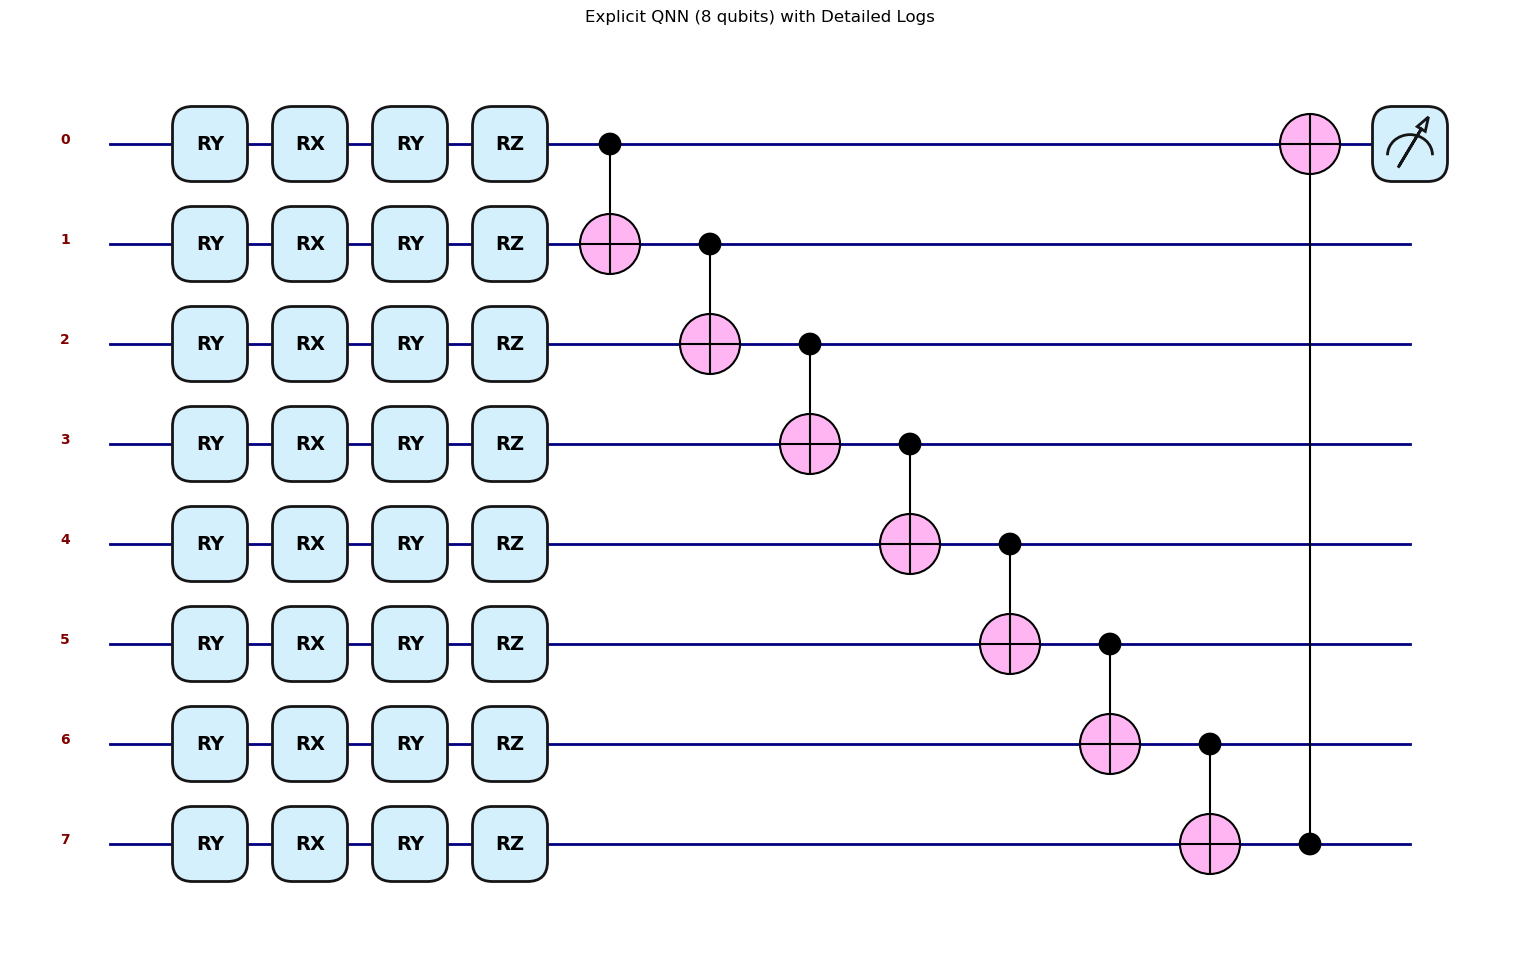

Epochs:   0%|          | 0/10 [00:01<?, ?it/s]

 Epoch 1 | Batch 1/350 | batch_loss=1.0176


Epochs:   0%|          | 0/10 [00:02<?, ?it/s]

 Epoch 1 | Batch 2/350 | batch_loss=0.9762


Epochs:   0%|          | 0/10 [00:04<?, ?it/s]

 Epoch 1 | Batch 3/350 | batch_loss=1.0072


Epochs:   0%|          | 0/10 [00:05<?, ?it/s]

 Epoch 1 | Batch 4/350 | batch_loss=1.0414


Epochs:   0%|          | 0/10 [00:07<?, ?it/s]

 Epoch 1 | Batch 5/350 | batch_loss=0.9754


Epochs:   0%|          | 0/10 [00:08<?, ?it/s]

 Epoch 1 | Batch 6/350 | batch_loss=1.0031


Epochs:   0%|          | 0/10 [00:09<?, ?it/s]

 Epoch 1 | Batch 7/350 | batch_loss=0.9911


Epochs:   0%|          | 0/10 [00:10<?, ?it/s]

 Epoch 1 | Batch 8/350 | batch_loss=0.9783


Epochs:   0%|          | 0/10 [00:12<?, ?it/s]

 Epoch 1 | Batch 9/350 | batch_loss=1.0130


Epochs:   0%|          | 0/10 [00:13<?, ?it/s]

 Epoch 1 | Batch 10/350 | batch_loss=1.0146


Epochs:   0%|          | 0/10 [00:14<?, ?it/s]

 Epoch 1 | Batch 11/350 | batch_loss=0.9876


Epochs:   0%|          | 0/10 [00:16<?, ?it/s]

 Epoch 1 | Batch 12/350 | batch_loss=1.0256


Epochs:   0%|          | 0/10 [00:17<?, ?it/s]

 Epoch 1 | Batch 13/350 | batch_loss=0.9770


Epochs:   0%|          | 0/10 [00:18<?, ?it/s]

 Epoch 1 | Batch 14/350 | batch_loss=1.0215


Epochs:   0%|          | 0/10 [00:19<?, ?it/s]

 Epoch 1 | Batch 15/350 | batch_loss=0.9897


Epochs:   0%|          | 0/10 [00:21<?, ?it/s]

 Epoch 1 | Batch 16/350 | batch_loss=0.9858


Epochs:   0%|          | 0/10 [00:22<?, ?it/s]

 Epoch 1 | Batch 17/350 | batch_loss=0.9884


Epochs:   0%|          | 0/10 [00:23<?, ?it/s]

 Epoch 1 | Batch 18/350 | batch_loss=1.0122


Epochs:   0%|          | 0/10 [00:24<?, ?it/s]

 Epoch 1 | Batch 19/350 | batch_loss=1.0201


Epochs:   0%|          | 0/10 [00:26<?, ?it/s]


 Epoch 1 | Batch 20/350 | batch_loss=1.0037


KeyboardInterrupt: 

In [4]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tqdm import trange, tqdm
import logging
import matplotlib.pyplot as plt

# ─────────────── 日志配置 ───────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger()

# ─────────────── 数据加载 & PCA 降维 ───────────────
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask = (y == "0") | (y == "1")
X, y = X[mask] / 255 * np.pi, y[mask].astype(int)

n_features = 8
pca = PCA(n_components=n_features)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# ─────────────── 超参与设备 ───────────────
n_qubits   = n_features
n_layers   = 1
batch_size = 32
n_batches  = len(X_train) // batch_size

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def explicit_qnn(x, weights):
    # RY 编码
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    # 可训练层：RX, RY, RZ + 环形 CNOT
    for i in range(n_qubits):
        qml.RX(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)
        qml.RZ(weights[0, i, 2], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    return qml.expval(qml.PauliZ(0))

# ─────────────── 初始化 & 优化器 ───────────────
np.random.seed(1)
weights_exp = np.random.normal(0, np.pi, (n_layers, n_qubits, 3), requires_grad=True)
opt_exp     = qml.GradientDescentOptimizer(stepsize=0.1)

# ─────────────── 彩色电路图 ───────────────
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(
    explicit_qnn,
    wire_order=range(n_qubits),
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "navy", "linewidth": 2},
    label_options={"size": 10, "color": "maroon"},
)(X_train[0], weights_exp)
ax.set_title("Explicit QNN (8 qubits) with Detailed Logs", pad=16)
plt.tight_layout()
plt.show()

epochs = 10

# ─────────────── 训练循环（带 Batch 和进度条） ───────────────
for epoch in trange(1, epochs + 1, desc="Epochs"):
    epoch_loss = 0.0

    for b in range(n_batches):
        start = b * batch_size
        end   = start + batch_size
        Xb, yb = X_train[start:end], y_train[start:end]

        def batch_loss(w):
            preds = np.array([explicit_qnn(x, w) for x in Xb])
            return np.mean((preds - (1 - 2 * yb)) ** 2)

        weights_exp, loss_b = opt_exp.step_and_cost(batch_loss, weights_exp)
        epoch_loss += loss_b

        # 打印每个 batch 的 loss
        tqdm.write(f" Epoch {epoch} | Batch {b+1}/{n_batches} | batch_loss={loss_b:.4f}")

    # 计算 epoch 平均 loss 与 accuracy
    avg_loss = epoch_loss / n_batches
    train_preds = np.array([explicit_qnn(x, weights_exp) for x in X_train]) > 0
    test_preds  = np.array([explicit_qnn(x, weights_exp) for x in X_test ]) > 0
    train_acc   = np.mean(train_preds == (y_train == 0))
    test_acc    = np.mean(test_preds  == (y_test  == 0))

    logger.info(
        f"[Epoch {epoch:2d}] avg_loss={avg_loss:.4f}  "
        f"train_acc={train_acc:.3f}  test_acc={test_acc:.3f}"
    )

